<a href="https://colab.research.google.com/github/ysooch0819/AI16-Projects/blob/main/n423%20%EA%B0%95%EC%9D%98%EB%85%B8%ED%8A%B8%20%ED%95%99%EC%8A%B5_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

class RNN:
  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    # 필요한 가중치 초기화
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.cache = None
  
  def forward(self, x, h_prev):
    Wx, Wh, b = self.params
    t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
    h_next = np.tanh(t)

    self.cache = (x, h_prev, h_next)
    return h_next

In [4]:
### RNN 은 모델이 아니라, 모델을 만드는데 쓰이는 층이다. LSTM, Attention 모두 마찬가지. 하나의 함수

In [5]:
from __future__ import print_function

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb

# 파라미터 설정
max_features = 20000
maxlen = 80
batch_size = 32

# 데이터 불러오기
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
17464789/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences


In [7]:
# Sequence를 Padding 해준다.
print('Pad Sequences (samples, maxlen)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)

Pad Sequences (samples, maxlen)
x_train shape:  (25000, 80)
x_test shape:  (25000, 80)


In [8]:
x_train[0]

array([   15,   256,     4,     2,     7,  3766,     5,   723,    36,
          71,    43,   530,   476,    26,   400,   317,    46,     7,
           4, 12118,  1029,    13,   104,    88,     4,   381,    15,
         297,    98,    32,  2071,    56,    26,   141,     6,   194,
        7486,    18,     4,   226,    22,    21,   134,   476,    26,
         480,     5,   144,    30,  5535,    18,    51,    36,    28,
         224,    92,    25,   104,     4,   226,    65,    16,    38,
        1334,    88,    12,    16,   283,     5,    16,  4472,   113,
         103,    32,    15,    16,  5345,    19,   178,    32],
      dtype=int32)

In [9]:
import tensorflow as tf

# model 정의
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(max_features, 128), # Embedding Layer를 거친 후의 shape: (batch_size, maxlen, embedding_size=128)
    tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2),# LSTM Layer를 거친 후의 shape: (batch_size, 1, hidden_size=128)
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


In [11]:
unicorns = model.fit(x_train, y_train,
                     batch_size=batch_size,
                     epochs=3,
                     validation_data=(x_test, y_test))

Epoch 1/3
782/782 [==============================] - 274s 346ms/step - loss: 0.4237 - accuracy: 0.7986 - val_loss: 0.3549 - val_accuracy: 0.8437
Epoch 2/3
782/782 [==============================] - 212s 271ms/step - loss: 0.2496 - accuracy: 0.8996 - val_loss: 0.3822 - val_accuracy: 0.8375
Epoch 3/3
782/782 [==============================] - 267s 341ms/step - loss: 0.1631 - accuracy: 0.9389 - val_loss: 0.4332 - val_accuracy: 0.8286


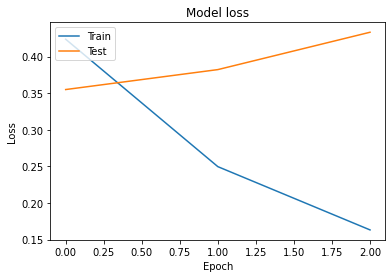

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(unicorns.history['loss'])
plt.plot(unicorns.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

In [13]:
# Keras를 이용한 LSTM 텍스트 생성기

from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import io
import IPython

path = get_file(
    'nietzschee.txt', origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
with io.open(path, encoding='utf-8') as f:
    text = f.read().lower()
print('corpus length: ', len(text))

chars = sorted(list(set(text)))
print('total chars: ', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

600901/600901 [==============================] - 0s 1us/step
corpus length:  600893
total chars:  57


In [14]:
maxlen = 40
step = 3

sentences = []
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i+maxlen])
print('nb sequences: ', len(sentences))
print('Vectorization...')

x = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]]=1

nb sequences:  200285
Vectorization...


In [15]:
# LSTM 모델 제작
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars)))) # maxlen길이의 문장, 원핫벡터
model.add(Dense(len(chars), activation='softmax'))

optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Build model...


In [16]:
# sample 문장 생성하는 함수
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# Epoch가 끝날때마다 samplee 문장을 생성하는 함수
def on_epoch_end(epoch, _):
    # clear_output : 이전 출력 지우기
    IPython.display.clear_output(wait=True)

    print()
    print('----- Generating text after Epoch: %d' % epoch)
    start_index = random.randint(0, len(text)-maxlen-1)

    # temperature를 조정하여 단어 선택 시 다양성 부여
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index+maxlen]
        generated +=sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]]=1.
            
            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

print_callback = LambdaCallback(on_epoch_end = on_epoch_end)

In [17]:
model.fit(x, y,
          batch_size=128,
          epochs=60,
          callbacks=[print_callback])


----- Generating text after Epoch: 59
----- diversity: 0.2
----- Generating with seed: "e: goethe's
"faust," part ii, act v. the"
e: goethe's
"faust," part ii, act v. the self-denial that is the such a philosopher and the self-denial that is the conserves of all the self-denial that in the subject of the self-destruction of the subject, and all the self-denial that is the self-probadocs the self-denial that is the self-denial that is it is a process to the process the self-denial that is the problem of the spirit and serve the subject of the self-denial that is th
----- diversity: 0.5
----- Generating with seed: "e: goethe's
"faust," part ii, act v. the"
e: goethe's
"faust," part ii, act v. the more that is he may be his degree of belong and deceive and indisintinal, and with the consequences of it possible and philosophical emotions as a man of the same and as he will also the continue and contemporaries and also the all the subject, and will at a doubt in the sense more the will
bel